In [1]:
import numpy as np
import pandas as pd
import os
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

In [16]:
data_directory = '../Data/'
hololenses = ['A/', 'B/']

In [3]:
def clean_df(df):
    result = df.loc[(df['Movement'] != "start") & (df['Movement'] != "transition") & (df['EyeTrackingEnabled'] == True) & (df['EyeCalibrationValid'] == True) & (df['EyeTrackingEnabledAndValid'] == True) & (df['EyeTrackingDataValid'] == True) & (df['GazeInputSource'] == "Eyes")].copy()
    #result = result[result['Movement'] != "transition"]
    #result = result[result['EyeTrackingDataValid'] == 'TRUE']
    #result = result[result['GazeInputSource'] == 'Eyes']
    result.reset_index(inplace=True, drop=True)
    return result

In [4]:
def calculate_euclidean_error(df):
    df['euclideanError'] = np.sqrt((df.GazeAngleX-df.TargetAngleX) * (df.GazeAngleX-df.TargetAngleX) + (df.GazeAngleY-df.TargetAngleY) * (df.GazeAngleY-df.TargetAngleY))
    return df

In [5]:
def shift_df(df, shift):
    if shift == 0:
        shifted_df = df.copy()
    else:
        shifted_df = df.copy()[:-shift]
    shifted_df.loc[:, ~shifted_df.columns.isin(['TargetAngleX', 'TargetAngleY', 'transform.position.x', 'transform.position.y', 'transform.position.z', 'localTransform.position.x', 'localTransform.position.y', 'localTransform.position.z', 'Movement'])] = df.loc[shift:, ~df.columns.isin(['TargetAngleX', 'TargetAngleY', 'transform.position.x', 'transform.position.y', 'transform.position.z', 'localTransform.position.x', 'localTransform.position.y', 'localTransform.position.z', 'Movement'])].to_numpy()
    #shifted_df.GazeAngleX = df['GazeAngleX'][shift:].values
    #shifted_df.GazeAngleY = df['GazeAngleY'][shift:].values
    return shifted_df


In [6]:
def find_best_shifted_df(df):
    startTime = datetime.strptime(df['Time'].iloc[0], "%m/%d/%Y %H:%M:%S.%f")
    shiftIndex = 0
    shiftTime = datetime.strptime(df['Time'].iloc[shiftIndex], "%m/%d/%Y %H:%M:%S.%f")
    timeDifference = shiftTime - startTime
    minError = float('inf')
    result = df
    bestShiftIndex = 0
    while (timeDifference.seconds < 1 and timeDifference.microseconds < 800000):
        shifted_df = shift_df(df, shiftIndex)
        shifted_df = calculate_euclidean_error(shifted_df)
        currentError = shifted_df['euclideanError'].mean()
        if (currentError < minError):
            minError = currentError
            result = shifted_df
            bestShiftIndex = shiftIndex
        shiftIndex = shiftIndex + 1
        shiftTime = datetime.strptime(df['Time'].iloc[shiftIndex], "%m/%d/%Y %H:%M:%S.%f")
        timeDifference = shiftTime - startTime
    result.drop(columns=['euclideanError'], inplace=True)
    return [bestShiftIndex, result]

In [14]:
def shift_files():
    for hololens in hololenses:
        participantList = os.listdir(data_directory + hololens)
        for participant in participantList:
            print(participant)
            if participant == '.DS_Store':
                print("skipping shifting")
                continue
            if os.path.exists(data_directory + hololens + participant + '/shifted/'):
                print("already shifted")
                continue
            fileList = os.listdir(data_directory + hololens + participant + '/raw/')
            for file in fileList:
                if '.csv' in file:
                    filePath = data_directory + hololens + participant + '/raw/' + file
                    data_df = pd.read_csv(filePath)
                    cleaned_df = clean_df(data_df)
                    [shiftIndex, shifted_df] = find_best_shifted_df(cleaned_df)
                    filePrefix = file.split('.')[0]
                    if not os.path.exists(data_directory + hololens + participant + '/shifted/'):
                        os.mkdir(data_directory + hololens + participant + '/shifted')
                    shiftedOutputFilePath = data_directory + hololens + participant + '/shifted/' + filePrefix + '_shifted' + str(shiftIndex) + '.csv'
                    shifted_df.to_csv(shiftedOutputFilePath, index=False)

In [24]:
shift_files()

03
already shifted
04
already shifted
32
already shifted
34
already shifted
05
already shifted
02
already shifted
.DS_Store
skipping shifting
18
already shifted
27
already shifted
29
already shifted
10
already shifted
19
already shifted
43
already shifted
07
already shifted
36
already shifted
09
already shifted
37
already shifted
08
already shifted
01
already shifted
06
already shifted
39
already shifted
46
already shifted
41
already shifted
49
already shifted
47
already shifted
25
already shifted
50
already shifted
35
already shifted
51
33
already shifted
.DS_Store
skipping shifting
20
already shifted
11
already shifted
16
already shifted
42
already shifted
45
already shifted
28
already shifted
17
already shifted
26
already shifted
21
already shifted
44
already shifted
38
already shifted
31
already shifted
30
already shifted
48
already shifted
24
already shifted
23
already shifted
15
already shifted
12
already shifted
40
already shifted
13
already shifted
14
already shifted
22
already

In [21]:
#sanity check - make sure you didn't pull the same files twice
data_directory_sanity_check = "../Data/Study/"
hololenses = ["A/", "B/"]
filenameList = []
for hololens in hololenses:
    participantList = os.listdir(data_directory_sanity_check + hololens)
    for participant in participantList:
        if not participant == '.DS_Store':
            fileList = os.listdir(data_directory_sanity_check + hololens + participant + '/raw/')
            for file in fileList:
                if not file == '.DS_Store':
                    if file in filenameList:
                        print(participant + '/raw/' + file)
                    else:
                        filenameList.append(file)

In [139]:
cleaned_df = clean_df(data_df)
[shiftIndex, shifted_df] = find_best_shifted_df(cleaned_df)

In [140]:
paths = data_file.split('/')
filePrefix = paths[-1].split('.')[0]
shiftedOutput = filePrefix + '_shifted_' + str(shiftIndex) + '.csv'
shiftedOutputFilePath = "../Data/Pilot/PS13/shifted/" + shiftedOutput
shifted_df.to_csv(shiftedOutputFilePath)

In [155]:
stripped_df = shifted_df[['Time','Frame','Movement','TargetAngleX','TargetAngleY','GazeAngleX','GazeAngleY','euclideanError']]
stripped_df['euclideanDistance'] = np.sqrt(stripped_df.TargetAngleX * stripped_df.TargetAngleX + stripped_df.TargetAngleY * stripped_df.TargetAngleY)
sorted_df = stripped_df.sort_values(by='euclideanDistance')

sortedOutputFilePath = "../Data/Pilot/PS13/shifted/" + filePrefix + "_shifted_" + str(shiftIndex) + "_sorted.csv"
sorted_df.to_csv(sortedOutputFilePath)

/var/folders/fd/prvd78ln6fddqyhkvtndyqb80000gn/T/ipykernel_15295/1494341100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stripped_df['euclideanDistance'] = np.sqrt(stripped_df.TargetAngleX * stripped_df.TargetAngleX + stripped_df.TargetAngleY * stripped_df.TargetAngleY)


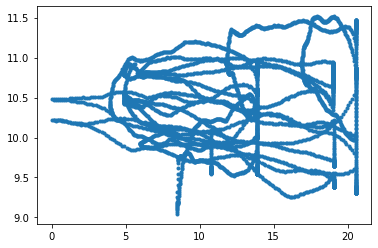

In [154]:
plt.plot(sorted_df['euclideanDistance'], sorted_df['euclideanError'], linestyle="None", marker='.')

In [158]:
pearsonr(sorted_df['euclideanDistance'], sorted_df['euclideanError'])

(0.021698723751992242, 0.13771398653534753)

In [164]:
test_directory = "../Data/Pilot/PS13/"
print(os.listdir(test_directory))

['.DS_Store', 'shifted', 'raw']


In [75]:
test_data = [[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15],[16,17,18,19,20]]
df = pd.DataFrame(test_data, columns=['a','TargetAngleX','TargetAngleY','GazeAngleX','GazeAngleY'])
test_shifted_df = df.loc[1:]
print(test_shifted_df)
print(df)
test_shifted = shift_df(df, 1)
#print(df)
print(test_shifted)

    a  TargetAngleX  TargetAngleY  GazeAngleX  GazeAngleY
1   6             7             8           9          10
2  11            12            13          14          15
3  16            17            18          19          20
    a  TargetAngleX  TargetAngleY  GazeAngleX  GazeAngleY
0   1             2             3           4           5
1   6             7             8           9          10
2  11            12            13          14          15
3  16            17            18          19          20
shifting
1
3
3
3
3
    a  TargetAngleX  TargetAngleY  GazeAngleX  GazeAngleY
0   6             2             3           9          10
1  11             7             8          14          15
2  16            12            13          19          20
